In [1]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  pass
#print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls "/content/gdrive/My Drive/ColorPalettes/Models/"

Mounted at /content/gdrive
decoder2.h5  discriminator2.h5	encoder.h5     start_epoch.npy
decoder.h5   discriminator.h5	loss_hist.npy


In [4]:
import numpy as np


class DataLoader():
    def __init__(self, data_path_imgs, data_path_colors, batch_size=4, testing=False):
        print("Loading Datasets ... may take a few ...")
        self.data_path_imgs = data_path_imgs
        self.dataset_imgs = np.load(self.data_path_imgs)['arr_0']

        self.data_path_colors = data_path_colors
        self.dataset_colors = np.load(self.data_path_colors)['arr_0']

        self.length = self.dataset_imgs.shape[0]

        self.batch_size = batch_size
        self.testing = testing
        self.translate_options = ['up', 'down', 'left', 'right']
        # self.enhance_dataset()
        print("Finished Loading Datasets.")

    def __len__(self):
        return int(np.floor(self.length / float(self.batch_size)))

    def translate(self, img, shift=10, direction='right', roll=True):
        assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
        img = img.copy()
        if direction == 'right':
            right_slice = img[:, -shift:].copy()
            img[:, shift:] = img[:, :-shift]
            if roll:
                img[:, :shift] = np.fliplr(right_slice)
        if direction == 'left':
            left_slice = img[:, :shift].copy()
            img[:, :-shift] = img[:, shift:]
            if roll:
                img[:, -shift:] = left_slice
        if direction == 'down':
            down_slice = img[-shift:, :].copy()
            img[shift:, :] = img[:-shift, :]
            if roll:
                img[:shift, :] = down_slice
        if direction == 'up':
            upper_slice = img[:shift, :].copy()
            img[:-shift, :] = img[shift:, :]
            if roll:
                img[-shift:, :] = upper_slice
        return img

    def load_batch(self):
        if not self.testing:
            self.shuffle_datasets_in_unison()
        for i in range(self.__len__()):
            img_batch = self.dataset_imgs[i * self.batch_size:(i + 1) * self.batch_size]
            color_batch = self.dataset_colors[i * self.batch_size:(i + 1) * self.batch_size]

            '''
            for i, img in enumerate(img_batch):
                img_batch[i,] = self.translate(img,shift=np.random.randint(1,20),direction = self.translate_options[np.random.randint(0,4)])
            '''

            for i, img in enumerate(img_batch):
                if np.random.randint(0, 2):
                    img_batch[i,] = np.flip(img, axis=0)

            for i, img in enumerate(img_batch):
                if np.random.randint(0, 2):
                    img_batch[i,] = np.flip(img, axis=1)
                    color_batch[i, ] = np.flip([color_batch[i]], axis=1)[0]

            '''
            for i, img in enumerate(img_batch):
                shift_value = np.random.uniform(-1.0,1.0)
                img_batch[i,] = hue_shift_without_luminance_distortion(img + 0.5, shift_value) - 0.5
                color_batch[i, ] = hue_shift_without_luminance_distortion([color_batch[i] + 0.5], shift_value) - 0.5
            '''
            
            yield img_batch, color_batch

    def shuffle_datasets_in_unison(self):
        rng_state = np.random.get_state()
        np.random.shuffle(self.dataset_imgs)
        np.random.set_state(rng_state)
        np.random.shuffle(self.dataset_colors)

    def change_batch_size(self, bs):
        self.batch_size = bs

In [5]:
batch_size = 32 # should be less than dataset size
train_loader = DataLoader("/content/gdrive/My Drive/ColorPalettes/imgs_normalized_lab.npz", "/content/gdrive/My Drive/ColorPalettes/colors_normalized_lab.npz", batch_size = batch_size)
test_loader = DataLoader("/content/gdrive/My Drive/ColorPalettes/test_imgs_normalized_lab.npz", "/content/gdrive/My Drive/ColorPalettes/test_colors_normalized_lab.npz", batch_size = 1, testing=True)

Loading Datasets ... may take a few ...
Finished Loading Datasets.
Loading Datasets ... may take a few ...
Finished Loading Datasets.


In [6]:
import keras.backend as K
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Activation, BatchNormalization, Dropout, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose, Concatenate
from keras.regularizers import l2
from keras import Model
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [7]:
latent_dim_size = 32
latent_dim_div = 16
beta = 2
reconstruction_weight = 150
activation = 'elu'

In [8]:

def conv2d(layer_input, filters, f_size=4, strides=1, bn=True, avg_pool=0, max_pool=0):
    """Layers used during downsampling"""
    d = keras.layers.Conv2D(filters, kernel_size=f_size, strides=strides, padding='same')(layer_input)
    d = keras.layers.LeakyReLU(alpha=0.2)(d)
    if bn:
        d = keras.layers.BatchNormalization(momentum=0.8)(d)
    if avg_pool:
        d = keras.layers.AveragePooling2D(pool_size=(2, 2))(d)
    if max_pool:
        d = keras.layers.MaxPooling2D(pool_size=(2, 2))(d)
    # d = keras.layers.Dropout(0.1)(d)
    return d

def build_encoder():
    encoder_inp = Input(shape=(64, 40, 3))

    conv = conv2d(encoder_inp, 3, 3, avg_pool=0, strides=(2,2))
    print(conv.shape)
    conv = conv2d(conv, 6, 3, avg_pool=0, strides=(2,2))
    print(conv.shape)
    conv = conv2d(conv, 12, 3, avg_pool=0, strides=(2,2))
    print(conv.shape)
    conv = conv2d(conv, 24, 3, avg_pool=0, strides=(2,2))
    print(conv.shape)
    conv = conv2d(conv, 32, 3, avg_pool=0, strides=(2,2))
    print(conv.shape)

    convcat = Flatten()(conv)

    convcat = Dense(64)(convcat)
    convcat = keras.layers.LeakyReLU(0.2)(convcat)

    mean_layer = Dense(latent_dim_size, activation=activation)(convcat)
    sd_layer = Dense(latent_dim_size, activation=activation)(convcat)

    return Model(encoder_inp, [mean_layer, sd_layer], name="VAE_Encoder")


def build_decoder():
    decoder_inp = Input(shape=(latent_dim_size,))
    noise_inp = Input(shape=(int(latent_dim_size/4),))
    '''
    #x = keras.layers.Flatten()(decoder_inp)
    #x = keras.layers.Conv1D(5,3)
    print(decoder_inp.shape)
    x = keras.layers.Reshape((32,1))(decoder_inp)
    print(x.shape)
    output = keras.layers.Conv1D(3,28)(x)
    print(output.shape)
    '''
    print("decoder inp:", decoder_inp.shape)
    x_inp = keras.layers.RepeatVector(5)(decoder_inp)
    x_noise = keras.layers.RepeatVector(5)(noise_inp)
    x = keras.layers.Concatenate()([x_inp, x_noise])
    print(x.shape)
    x = keras.layers.Bidirectional(keras.layers.GRU(16, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(x)
    print(x.shape)
    #x = keras.layers.Bidirectional(keras.layers.GRU(12, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(x)
    print(x.shape)
    x = keras.layers.Bidirectional(keras.layers.GRU(8, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(x)
    print(x.shape)
    x = keras.layers.Bidirectional(keras.layers.GRU(8, return_sequences=True), merge_mode='concat')(x)
    print(x.shape)
    output = keras.layers.TimeDistributed(keras.layers.Dense(5))(x)
    output = keras.layers.TimeDistributed(keras.layers.Dense(3))(x)
    #output = keras.layers.Conv1D(3,1)(output)
    

    print(output.shape)

    return Model([decoder_inp, noise_inp], output, name="VAE_Decoder")

def build_discriminator():
    disc_in = Input(shape = (5,3))
    disc_in2 = Input(shape = (64,40,3))

    disc = keras.layers.Bidirectional(keras.layers.GRU(4, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(disc_in)
    disc = keras.layers.Bidirectional(keras.layers.GRU(8, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(disc)
    #disc = keras.layers.Bidirectional(keras.layers.GRU(12, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(disc)
    disc = keras.layers.Bidirectional(keras.layers.GRU(16, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(disc)
    disc = keras.layers.TimeDistributed(keras.layers.Dense(16))(disc)
    disc = keras.layers.Flatten()(disc)

    disc2 = conv2d(disc_in2, 3, 3, avg_pool=0, strides=(2,2))
    disc2 = conv2d(disc2, 6, 3,  avg_pool=0, strides=(2,2))
    disc2 = conv2d(disc2, 12, 3,  avg_pool=0, strides=(2,2))
    disc2 = conv2d(disc2, 24, 3, avg_pool=0, strides=(2,2))
    disc2 = conv2d(disc2, 32, 3, avg_pool=0, strides=(2,2))
    disc2 = keras.layers.Flatten()(disc2)

    disc2 = keras.layers.Concatenate(axis=1)([disc, disc2])

    disc2 = keras.layers.Dense(100)(disc2)
    disc_pre_out = keras.layers.Dense(50, activation='relu')(disc2)
    disc_out = keras.layers.Dense(1, activation='sigmoid')(disc_pre_out)

    return Model([disc_in, disc_in2], [disc_out, disc], name="Discriminator")

def build_second_discriminator():
    disc_in = Input(shape = (5,3))
    disc = keras.layers.Bidirectional(keras.layers.GRU(4, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(disc_in)
    disc = keras.layers.Bidirectional(keras.layers.GRU(8, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(disc)
    #disc = keras.layers.Bidirectional(keras.layers.GRU(12, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(disc)
    disc = keras.layers.Bidirectional(keras.layers.GRU(16, return_sequences=True, dropout=0.1, recurrent_dropout=0.1), merge_mode='concat')(disc)
    disc = keras.layers.TimeDistributed(keras.layers.Dense(16))(disc)
    disc = keras.layers.Flatten()(disc)

    disc = keras.layers.Dense(32)(disc)
    disc_pre_out = keras.layers.Dense(25, activation='relu')(disc)
    disc_out = keras.layers.Dense(1, activation='sigmoid')(disc_pre_out)

    return Model(disc_in, [disc_out, disc], name="Discriminator")

encoder = build_encoder()
decoder = build_decoder()
discriminator = build_discriminator()
discriminator2 = build_second_discriminator()
print(discriminator.summary())
#######################################################################################################################
"""
  COMPUTATIONAL GRAPH HERE
"""
# Computational Graph goes here
def _sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
       Instead of sampling from Q(z|X), sample eps = N(0,I)
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

sampler = Lambda(_sampling, output_shape=(latent_dim_size,), name='sampler')

x = Input(shape=(64,40,3), name='input_image')
# z_p is sampled directly from isotropic gaussian
z_p = Input(shape=(latent_dim_size,), name='z_p')
z_noise = Input(shape=(int(latent_dim_size/4),), name='z_noise')

# real color palette
real = Input(shape=(5,3))

z_mean, z_log_var = encoder(x)
z = sampler([z_mean, z_log_var])

x_tilde = decoder([z, z_noise])
x_p = decoder([z_p, z_noise])



dis_x, dis_feat = discriminator([real, x])
dis_x_tilde, dis_feat_tilde = discriminator([x_tilde, x])
dis_x_p = discriminator([x_p, x])[0]

dis_x2, dis_feat2 = discriminator2(real)
dis_x_tilde2, dis_feat_tilde2 = discriminator2(x_tilde)
dis_x_p2 = discriminator2(x_p)[0]


def mean_gaussian_negative_log_likelihood(y_true, y_pred):
    nll = 0.5 * np.log(2 * np.pi) + 0.5 * K.square(y_pred - y_true)
    axis = tuple(range(1, len(K.int_shape(y_true))))
    return K.mean(K.sum(nll, axis=axis), axis=-1)

dis_nll_loss = mean_gaussian_negative_log_likelihood(dis_feat, dis_feat_tilde)

kl_loss = K.mean(-0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
#reconstruction_loss = K.sum(K.square(x_tilde-real)) * 50
encoder_train = Model([real, x, z_noise], dis_x_tilde, name='e')
encoder_train.add_loss(kl_loss)
#encoder_train.add_loss(reconstruction_loss)
encoder_train.add_loss(dis_nll_loss)

recon_vs_gan_weight = 1e-6
normalized_weight = recon_vs_gan_weight / (1. - recon_vs_gan_weight)

decoder_train = Model([real, x, z_p, z_noise], [dis_x_tilde, dis_x_p], name='de')
decoder_train.add_loss(normalized_weight * dis_nll_loss)

decoder_train2 = Model([real, x, z_p, z_noise], [dis_x_tilde2, dis_x_p2], name='de')
decoder_train2.add_loss(normalized_weight * dis_nll_loss)

discriminator_train = Model([real, x, z_p, z_noise], [dis_x, dis_x_tilde, dis_x_p], name='di')

discriminator_train2 = Model([real, x, z_p, z_noise], [dis_x2, dis_x_tilde2, dis_x_p2], name='di2')

# Additional models for testing
vae = Model([x, z_noise], x_tilde, name='vae')

vaegan = Model([x, z_noise], dis_x_tilde, name='vaegan')
print(vaegan.summary())

########################################################################################################################
# Compile models correctly

def set_trainable(model, trainable):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable

import tensorflow
rmsprop1 = keras.optimizers.Adam(lr=0.0005, beta_1=0.5)
rmsprop2 = keras.optimizers.Adam(lr=0.002, beta_1=0.5)

set_trainable(encoder, False)
set_trainable(decoder, False)
discriminator_train.compile(rmsprop2, ['mse'] * 3, ['acc'] * 3)
#discriminator_train.summary()

discriminator_train2.compile(rmsprop2, ['mse'] * 3, ['acc'] * 3)
#discriminator_train2.summary()

set_trainable(discriminator, False)
set_trainable(discriminator2, False)
set_trainable(decoder, True)
decoder_train.compile(rmsprop1, ['mse'] * 2, ['acc'] * 2)
decoder_train2.compile(rmsprop1, ['mse'] * 2, ['acc'] * 2)
#decoder_train.summary()

set_trainable(decoder, False)
set_trainable(encoder, True)
encoder_train.compile(rmsprop1)
#encoder_train.summary()

set_trainable(vaegan, True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 32, 20, 3)
(?, 16, 10, 6)
(?, 8, 5, 12)
(?, 4, 3, 24)
(?, 2, 2, 32)
decoder inp: (?, 32)
(?, 5, 40)
(?, 5, 32)
(?, 5, 32)
(?, 5, 16)
(?, 5, 16)
(?, 5, 3)
Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 40, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 20, 3)    84          input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 32, 20, 3)    0           conv2d_6[0][0]                   
_____________________________________________

/tensorflow-1.15.2/python3.7/keras/engine/training_utils.py:819: UserWarning: Output Discriminator missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to Discriminator.
  'be expecting any data to be passed to {0}.'.format(name))


In [9]:
print(decoder_train.loss)

['mse', 'mse']


In [10]:
from skimage import color
def denormalize_lab(lab):
    L, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

    L = (L + 1) * 50
    a = a * 128
    b = b * 128

    Lab = np.stack([L, a, b], axis=2)
    return Lab

def show_image(x):
    x = denormalize_lab(x)
    x = color.lab2rgb(x)
    plt.imshow(x)

In [11]:
batch_size = 32
train_loader.batch_size = batch_size

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


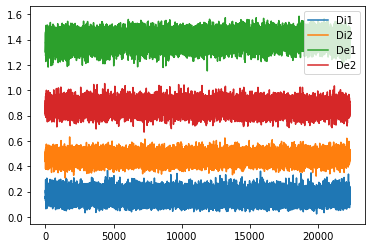

EPOCH : 332 BATCH :  0 DISC LOSS :  [0.11645069, 0.054114178, 0.033999298, 0.028337216, 0.0, 0.9375, 0.96875] DEC LOSS :  [1.4513569, 0.70677036, 0.74448127, 0.0, 0.0] ENC LOSS :  108.278465
DISC LOSS 2 :  [0.44561765, 0.3071465, 0.08328435, 0.055186816, 0.0, 0.9375, 0.96875] DEC LOSS 2 :  [0.9047988, 0.4510176, 0.45367885, 0.0, 0.0]
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)


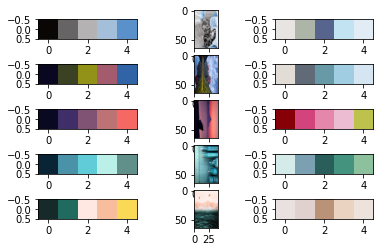

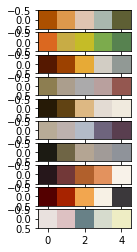

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


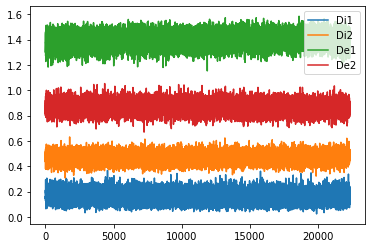

EPOCH : 332 BATCH :  1 DISC LOSS :  [0.11675213, 0.06238527, 0.030793257, 0.023573611, 0.0, 0.9375, 0.96875] DEC LOSS :  [1.4581729, 0.7134954, 0.7445723, 0.0, 0.0] ENC LOSS :  111.12183
DISC LOSS 2 :  [0.44828957, 0.29023132, 0.08350289, 0.07455538, 0.0, 0.96875, 0.9375] DEC LOSS 2 :  [0.83126044, 0.3995599, 0.43159473, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


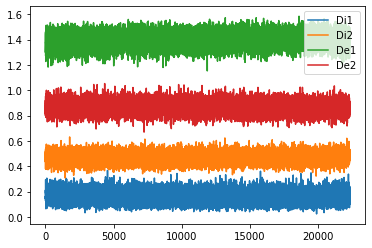

EPOCH : 332 BATCH :  2 DISC LOSS :  [0.14899458, 0.08258061, 0.06313344, 0.003280534, 0.0, 0.9375, 1.0] DEC LOSS :  [1.3364332, 0.6652409, 0.6710818, 0.0, 0.0] ENC LOSS :  109.55822
DISC LOSS 2 :  [0.48201907, 0.2966029, 0.08545911, 0.099957034, 0.0, 0.9375, 0.90625] DEC LOSS 2 :  [0.8170693, 0.41657805, 0.40038347, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


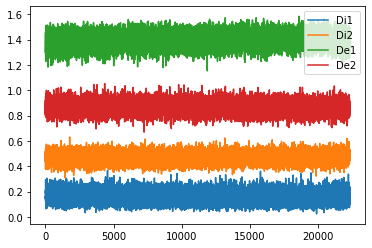

EPOCH : 332 BATCH :  3 DISC LOSS :  [0.17697625, 0.056908913, 0.10901842, 0.0110489065, 0.0, 0.8125, 1.0] DEC LOSS :  [1.434922, 0.7314349, 0.70338166, 0.0, 0.0] ENC LOSS :  112.48204
DISC LOSS 2 :  [0.46047962, 0.28341046, 0.066605136, 0.11046404, 0.0, 1.0, 0.84375] DEC LOSS 2 :  [0.84153277, 0.43495482, 0.40647298, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


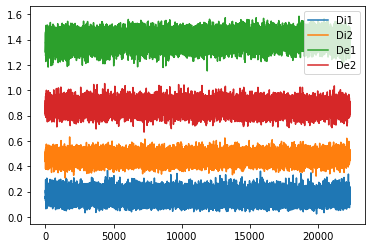

EPOCH : 332 BATCH :  4 DISC LOSS :  [0.19654132, 0.07754207, 0.0876952, 0.031304047, 0.0, 0.84375, 0.96875] DEC LOSS :  [1.4489459, 0.69757116, 0.75126916, 0.0, 0.0] ENC LOSS :  108.1694
DISC LOSS 2 :  [0.44913566, 0.2747612, 0.095483035, 0.07889144, 0.0, 0.875, 0.96875] DEC LOSS 2 :  [0.8632328, 0.4130949, 0.45002952, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


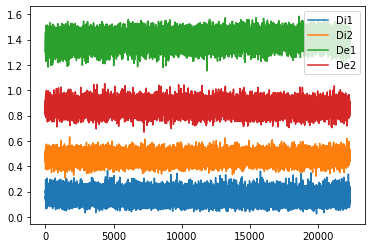

EPOCH : 332 BATCH :  5 DISC LOSS :  [0.19689582, 0.035865486, 0.10062681, 0.060403522, 0.0, 0.84375, 0.90625] DEC LOSS :  [1.4208276, 0.62715644, 0.7935655, 0.0, 0.0] ENC LOSS :  109.80466
DISC LOSS 2 :  [0.44212788, 0.27513176, 0.079296105, 0.0877, 0.0, 0.96875, 0.96875] DEC LOSS 2 :  [0.8627945, 0.47443, 0.3882581, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


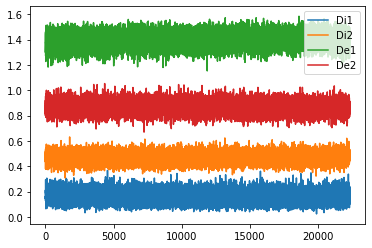

EPOCH : 332 BATCH :  6 DISC LOSS :  [0.1764623, 0.13278872, 0.018786721, 0.024886847, 0.0, 0.96875, 0.96875] DEC LOSS :  [1.4178735, 0.7249005, 0.69286525, 0.0, 0.0] ENC LOSS :  111.98337
DISC LOSS 2 :  [0.5131108, 0.29159164, 0.1471122, 0.074407004, 0.0, 0.75, 0.96875] DEC LOSS 2 :  [0.8749135, 0.41267598, 0.46212658, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


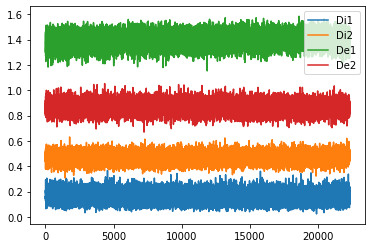

EPOCH : 332 BATCH :  7 DISC LOSS :  [0.13268016, 0.091272585, 0.023427805, 0.017979767, 0.0, 0.96875, 1.0] DEC LOSS :  [1.4616511, 0.73804474, 0.7235011, 0.0, 0.0] ENC LOSS :  108.4959
DISC LOSS 2 :  [0.44641763, 0.29528645, 0.085539356, 0.06559182, 0.0, 0.90625, 1.0] DEC LOSS 2 :  [0.89477724, 0.45642918, 0.43824327, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


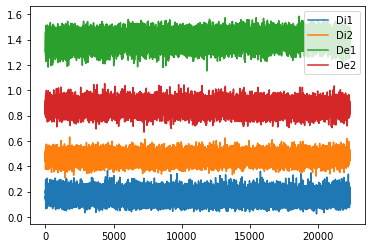

EPOCH : 332 BATCH :  8 DISC LOSS :  [0.17753752, 0.1535343, 0.018553378, 0.005449842, 0.0, 0.96875, 1.0] DEC LOSS :  [1.4838101, 0.7399441, 0.74375945, 0.0, 0.0] ENC LOSS :  109.439476
DISC LOSS 2 :  [0.484355, 0.30272382, 0.08179556, 0.099835604, 0.0, 0.96875, 0.90625] DEC LOSS 2 :  [0.84978795, 0.414898, 0.43478137, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


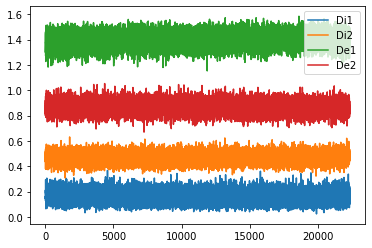

EPOCH : 332 BATCH :  9 DISC LOSS :  [0.16480625, 0.10435377, 0.054894272, 0.005558204, 0.0, 0.90625, 1.0] DEC LOSS :  [1.3849037, 0.6193871, 0.7654102, 0.0, 0.0] ENC LOSS :  107.650154
DISC LOSS 2 :  [0.48778877, 0.32773656, 0.09002054, 0.07003168, 0.0, 0.9375, 1.0] DEC LOSS 2 :  [0.831588, 0.39785343, 0.43363065, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


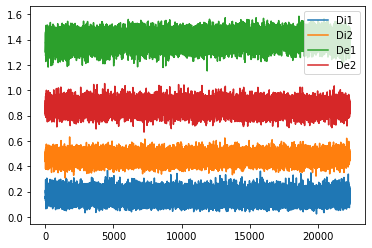

EPOCH : 332 BATCH :  10 DISC LOSS :  [0.17283237, 0.05851333, 0.045633428, 0.068685606, 0.0, 0.9375, 0.90625] DEC LOSS :  [1.31902, 0.6072303, 0.71168256, 0.0, 0.0] ENC LOSS :  113.47989
DISC LOSS 2 :  [0.4593575, 0.3066941, 0.07087601, 0.081787415, 0.0, 0.96875, 0.90625] DEC LOSS 2 :  [0.9211001, 0.47766408, 0.44332778, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


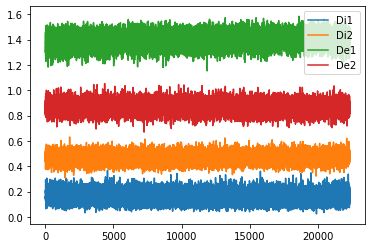

EPOCH : 332 BATCH :  11 DISC LOSS :  [0.15258135, 0.09338185, 0.0151563585, 0.044043142, 0.0, 0.96875, 0.9375] DEC LOSS :  [1.3656267, 0.6228651, 0.7426552, 0.0, 0.0] ENC LOSS :  107.93684
DISC LOSS 2 :  [0.43097782, 0.29614827, 0.067314655, 0.06751491, 0.0, 0.96875, 1.0] DEC LOSS 2 :  [0.9499268, 0.47118413, 0.47863793, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


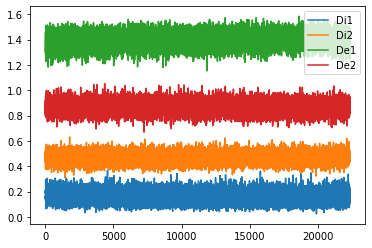

EPOCH : 332 BATCH :  12 DISC LOSS :  [0.15011153, 0.037054956, 0.08160223, 0.031454332, 0.0, 0.875, 0.9375] DEC LOSS :  [1.2475551, 0.57976687, 0.6676808, 0.0, 0.0] ENC LOSS :  112.47336
DISC LOSS 2 :  [0.44528615, 0.29365048, 0.066439256, 0.08519644, 0.0, 1.0, 0.96875] DEC LOSS 2 :  [0.90924805, 0.4445514, 0.46459275, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


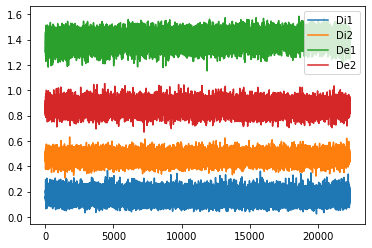

EPOCH : 332 BATCH :  13 DISC LOSS :  [0.15577728, 0.074791506, 0.049621157, 0.03136462, 0.0, 0.90625, 0.9375] DEC LOSS :  [1.3708981, 0.68101674, 0.6897721, 0.0, 0.0] ENC LOSS :  111.27841
DISC LOSS 2 :  [0.48820916, 0.298809, 0.11058666, 0.07881352, 0.0, 0.9375, 0.90625] DEC LOSS 2 :  [0.83829445, 0.41572136, 0.42246404, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


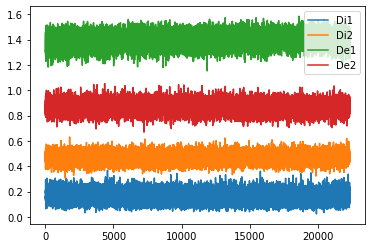

EPOCH : 332 BATCH :  14 DISC LOSS :  [0.26845273, 0.115386866, 0.14188808, 0.011177786, 0.0, 0.75, 1.0] DEC LOSS :  [1.4620576, 0.7029753, 0.7589761, 0.0, 0.0] ENC LOSS :  110.775276
DISC LOSS 2 :  [0.448098, 0.28375512, 0.08475026, 0.07959262, 0.0, 0.96875, 0.96875] DEC LOSS 2 :  [0.9135768, 0.45720395, 0.4562684, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


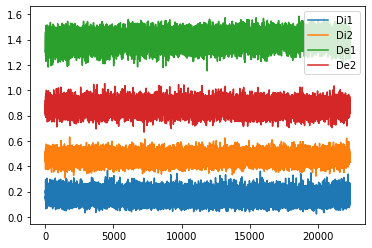

EPOCH : 332 BATCH :  15 DISC LOSS :  [0.0901389, 0.039514534, 0.020764275, 0.029860089, 0.0, 0.96875, 0.96875] DEC LOSS :  [1.4674801, 0.7172059, 0.75016737, 0.0, 0.0] ENC LOSS :  111.75073
DISC LOSS 2 :  [0.4316653, 0.2620098, 0.09010194, 0.079553545, 0.0, 0.9375, 0.96875] DEC LOSS 2 :  [0.90663093, 0.43639308, 0.47013152, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


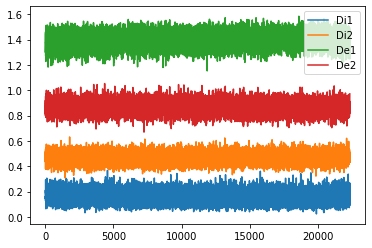

EPOCH : 332 BATCH :  16 DISC LOSS :  [0.16268763, 0.06459704, 0.094941, 0.0031496051, 0.0, 0.84375, 1.0] DEC LOSS :  [1.4316014, 0.67800176, 0.75349516, 0.0, 0.0] ENC LOSS :  111.46395
DISC LOSS 2 :  [0.46243227, 0.28696203, 0.09624417, 0.07922606, 0.0, 0.90625, 0.9375] DEC LOSS 2 :  [0.9716823, 0.44637895, 0.5251924, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


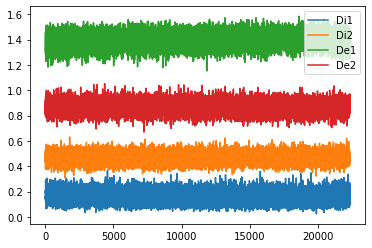

EPOCH : 332 BATCH :  17 DISC LOSS :  [0.19494331, 0.119431436, 0.0636732, 0.011838671, 0.0, 0.90625, 0.96875] DEC LOSS :  [1.4254571, 0.6831912, 0.74216, 0.0, 0.0] ENC LOSS :  109.6896
DISC LOSS 2 :  [0.4051338, 0.26092145, 0.061330006, 0.082882375, 0.0, 0.96875, 0.9375] DEC LOSS 2 :  [0.8996904, 0.45333967, 0.44624642, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


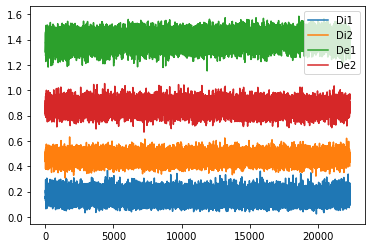

EPOCH : 332 BATCH :  18 DISC LOSS :  [0.18897612, 0.09905578, 0.086661234, 0.0032591007, 0.0, 0.875, 1.0] DEC LOSS :  [1.475805, 0.70649093, 0.76921046, 0.0, 0.0] ENC LOSS :  106.59142
DISC LOSS 2 :  [0.4026994, 0.2603792, 0.081295095, 0.061025098, 0.0, 0.96875, 1.0] DEC LOSS 2 :  [0.9311721, 0.46326658, 0.46779817, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


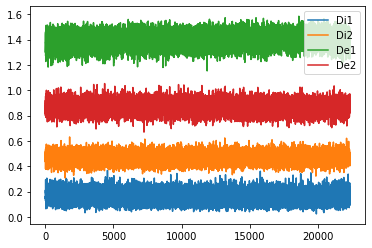

EPOCH : 332 BATCH :  19 DISC LOSS :  [0.21575314, 0.06312281, 0.12162735, 0.031002965, 0.0, 0.8125, 0.96875] DEC LOSS :  [1.4352661, 0.66063845, 0.77452606, 0.0, 0.0] ENC LOSS :  111.14211
DISC LOSS 2 :  [0.49656484, 0.33200115, 0.07970923, 0.084854454, 0.0, 0.9375, 0.9375] DEC LOSS 2 :  [0.87374824, 0.41456655, 0.4590782, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


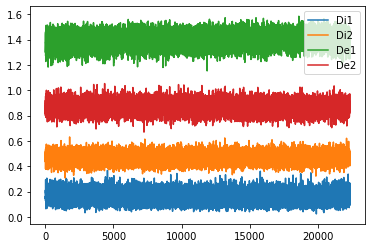

EPOCH : 332 BATCH :  20 DISC LOSS :  [0.2630087, 0.1618295, 0.08408705, 0.017092183, 0.0, 0.875, 0.96875] DEC LOSS :  [1.4487196, 0.70392334, 0.74469125, 0.0, 0.0] ENC LOSS :  107.01776
DISC LOSS 2 :  [0.5180892, 0.3570071, 0.09196216, 0.06911996, 0.0, 0.9375, 0.9375] DEC LOSS 2 :  [0.8860127, 0.39833367, 0.48757446, 0.0, 0.0]
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)


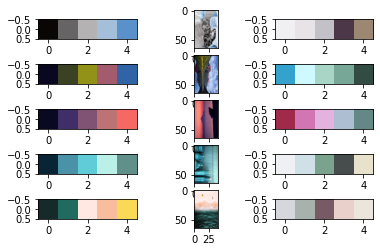

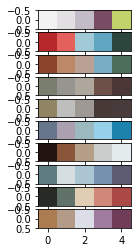

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


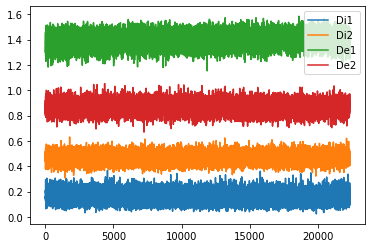

EPOCH : 332 BATCH :  21 DISC LOSS :  [0.21466167, 0.09448702, 0.099773034, 0.020401616, 0.0, 0.84375, 0.96875] DEC LOSS :  [1.4269795, 0.64239115, 0.78448576, 0.0, 0.0] ENC LOSS :  107.89689
DISC LOSS 2 :  [0.44057402, 0.28932256, 0.0862935, 0.064957954, 0.0, 0.9375, 0.96875] DEC LOSS 2 :  [0.91651946, 0.45248544, 0.46392915, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


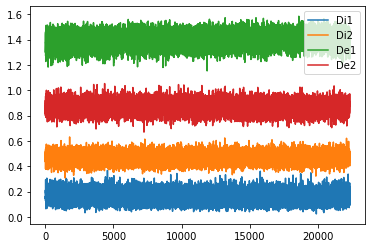

EPOCH : 332 BATCH :  22 DISC LOSS :  [0.15859273, 0.12487069, 0.03283661, 0.0008854284, 0.0, 0.96875, 1.0] DEC LOSS :  [1.4615685, 0.7370019, 0.72445667, 0.0, 0.0] ENC LOSS :  109.39979
DISC LOSS 2 :  [0.47846276, 0.30841577, 0.10846497, 0.06158202, 0.0, 0.875, 0.96875] DEC LOSS 2 :  [0.8758913, 0.3855126, 0.49027115, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


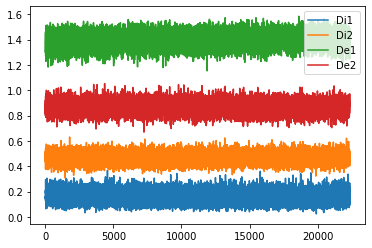

EPOCH : 332 BATCH :  23 DISC LOSS :  [0.18323861, 0.08931571, 0.048488304, 0.04543459, 0.0, 0.875, 0.9375] DEC LOSS :  [1.4649588, 0.7367836, 0.72806644, 0.0, 0.0] ENC LOSS :  111.54117
DISC LOSS 2 :  [0.44543868, 0.28162485, 0.09475768, 0.06905615, 0.0, 0.96875, 0.96875] DEC LOSS 2 :  [0.88997686, 0.41403872, 0.47583264, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


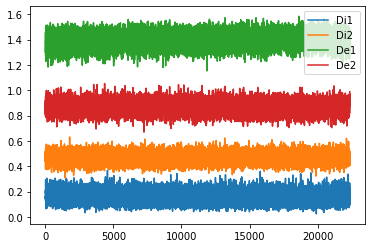

EPOCH : 332 BATCH :  24 DISC LOSS :  [0.115305305, 0.07284949, 0.017887065, 0.024568751, 0.0, 0.96875, 0.96875] DEC LOSS :  [1.2894673, 0.62623906, 0.66312134, 0.0, 0.0] ENC LOSS :  110.72987
DISC LOSS 2 :  [0.41221344, 0.26004326, 0.0819435, 0.070226684, 0.0, 0.90625, 0.96875] DEC LOSS 2 :  [0.9883892, 0.49395752, 0.49432483, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


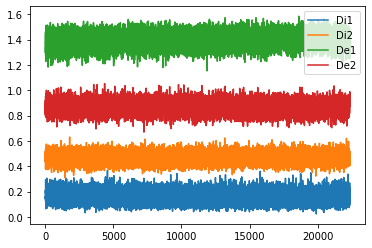

EPOCH : 332 BATCH :  25 DISC LOSS :  [0.16521624, 0.057428196, 0.07470882, 0.033079218, 0.0, 0.875, 0.96875] DEC LOSS :  [1.2879556, 0.5981977, 0.6896531, 0.0, 0.0] ENC LOSS :  107.505714
DISC LOSS 2 :  [0.42971763, 0.3081141, 0.07139517, 0.050208356, 0.0, 0.96875, 0.96875] DEC LOSS 2 :  [0.9000431, 0.47043246, 0.4295042, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


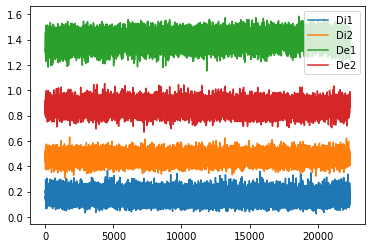

EPOCH : 332 BATCH :  26 DISC LOSS :  [0.18859923, 0.11211371, 0.055596754, 0.020888776, 0.0, 0.9375, 1.0] DEC LOSS :  [1.3261971, 0.6298469, 0.69624573, 0.0, 0.0] ENC LOSS :  105.74251
DISC LOSS 2 :  [0.4431973, 0.27996385, 0.07893335, 0.0843001, 0.0, 0.96875, 0.96875] DEC LOSS 2 :  [0.8664542, 0.43074176, 0.43560833, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


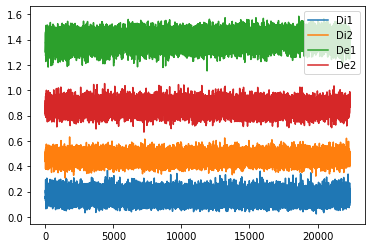

EPOCH : 332 BATCH :  27 DISC LOSS :  [0.17008668, 0.04999136, 0.070611715, 0.049483597, 0.0, 0.875, 0.90625] DEC LOSS :  [1.3034207, 0.5985228, 0.7047883, 0.0, 0.0] ENC LOSS :  109.805374
DISC LOSS 2 :  [0.3983823, 0.24074757, 0.06978282, 0.0878519, 0.0, 0.96875, 0.90625] DEC LOSS 2 :  [0.8668977, 0.4343332, 0.43246102, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


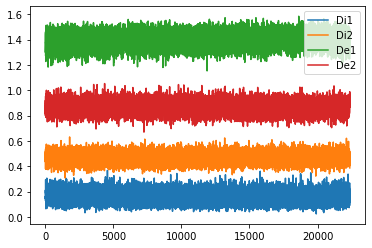

EPOCH : 332 BATCH :  28 DISC LOSS :  [0.1243328, 0.028268088, 0.08550796, 0.010556757, 0.0, 0.90625, 1.0] DEC LOSS :  [1.3535106, 0.6409914, 0.7124157, 0.0, 0.0] ENC LOSS :  110.19084
DISC LOSS 2 :  [0.3871356, 0.27326658, 0.052179586, 0.061689436, 0.0, 1.0, 0.96875] DEC LOSS 2 :  [0.93258977, 0.44690832, 0.48557538, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


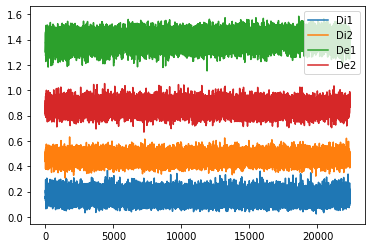

EPOCH : 332 BATCH :  29 DISC LOSS :  [0.11073178, 0.028080832, 0.080775015, 0.0018759399, 0.0, 0.90625, 1.0] DEC LOSS :  [1.4597756, 0.6890208, 0.77064824, 0.0, 0.0] ENC LOSS :  108.36395
DISC LOSS 2 :  [0.42604202, 0.2607891, 0.06503019, 0.10022272, 0.0, 1.0, 0.9375] DEC LOSS 2 :  [0.8768822, 0.43726504, 0.4395067, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


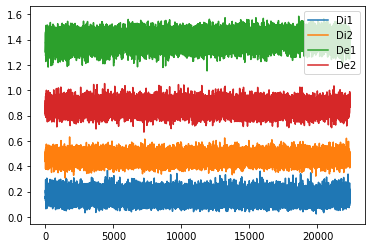

EPOCH : 332 BATCH :  30 DISC LOSS :  [0.14268257, 0.10832266, 0.0105725685, 0.023787344, 0.0, 1.0, 0.96875] DEC LOSS :  [1.3793551, 0.63180673, 0.7474419, 0.0, 0.0] ENC LOSS :  111.86413
DISC LOSS 2 :  [0.4626071, 0.27210665, 0.09767367, 0.09282678, 0.0, 0.90625, 0.875] DEC LOSS 2 :  [0.931959, 0.51798904, 0.41386306, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


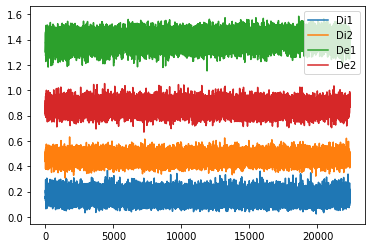

EPOCH : 332 BATCH :  31 DISC LOSS :  [0.12747021, 0.10912669, 0.016824914, 0.0015186084, 0.0, 0.96875, 1.0] DEC LOSS :  [1.3893068, 0.6643872, 0.72481287, 0.0, 0.0] ENC LOSS :  108.696945
DISC LOSS 2 :  [0.42750996, 0.27621907, 0.07111481, 0.08017608, 0.0, 0.9375, 0.96875] DEC LOSS 2 :  [0.9311438, 0.49885446, 0.43218344, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


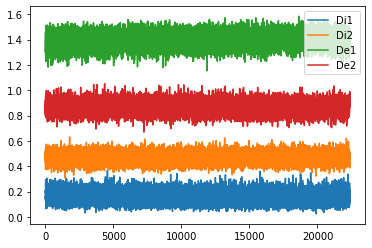

EPOCH : 332 BATCH :  32 DISC LOSS :  [0.2126812, 0.08609896, 0.051482216, 0.07510004, 0.0, 0.90625, 0.90625] DEC LOSS :  [1.4765658, 0.73487633, 0.7415802, 0.0, 0.0] ENC LOSS :  112.48159
DISC LOSS 2 :  [0.4360143, 0.2876168, 0.07278211, 0.075615406, 0.0, 0.90625, 0.9375] DEC LOSS 2 :  [0.98159677, 0.5066247, 0.47486448, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


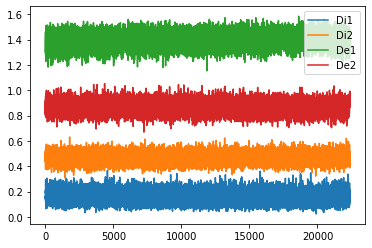

EPOCH : 332 BATCH :  33 DISC LOSS :  [0.12992938, 0.03026386, 0.07504256, 0.024622964, 0.0, 0.875, 0.96875] DEC LOSS :  [1.4408644, 0.6993361, 0.74141765, 0.0, 0.0] ENC LOSS :  112.50052
DISC LOSS 2 :  [0.567822, 0.28283012, 0.12176879, 0.16322306, 0.0, 0.875, 0.84375] DEC LOSS 2 :  [0.9910852, 0.5244992, 0.46647635, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


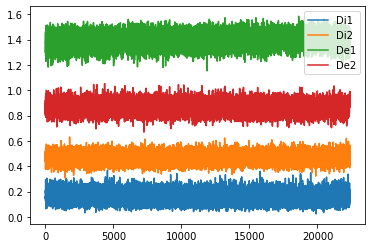

EPOCH : 332 BATCH :  34 DISC LOSS :  [0.1456997, 0.061934493, 0.04964009, 0.034125112, 0.0, 0.9375, 0.9375] DEC LOSS :  [1.4706582, 0.70913553, 0.76141274, 0.0, 0.0] ENC LOSS :  110.22204
DISC LOSS 2 :  [0.4896695, 0.32081014, 0.074402444, 0.094456926, 0.0, 0.9375, 0.9375] DEC LOSS 2 :  [0.8794292, 0.4560422, 0.4232792, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


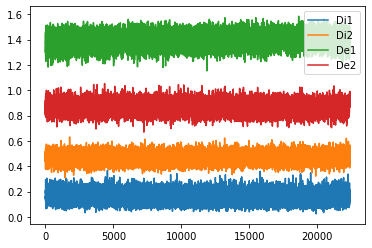

EPOCH : 332 BATCH :  35 DISC LOSS :  [0.12804846, 0.07404033, 0.038930744, 0.015077396, 0.0, 0.96875, 0.96875] DEC LOSS :  [1.5149797, 0.7335244, 0.7813512, 0.0, 0.0] ENC LOSS :  107.868546
DISC LOSS 2 :  [0.4713589, 0.32042488, 0.058746696, 0.092187315, 0.0, 0.96875, 0.9375] DEC LOSS 2 :  [0.9420915, 0.48295334, 0.45903188, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


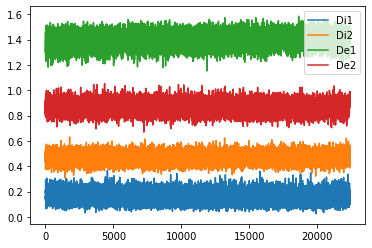

EPOCH : 332 BATCH :  36 DISC LOSS :  [0.103610635, 0.06447486, 0.019314729, 0.01982105, 0.0, 1.0, 0.96875] DEC LOSS :  [1.4146571, 0.639243, 0.77530766, 0.0, 0.0] ENC LOSS :  112.482376
DISC LOSS 2 :  [0.4606691, 0.31938937, 0.080286786, 0.06099297, 0.0, 0.96875, 0.96875] DEC LOSS 2 :  [0.97233623, 0.50523055, 0.46700197, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


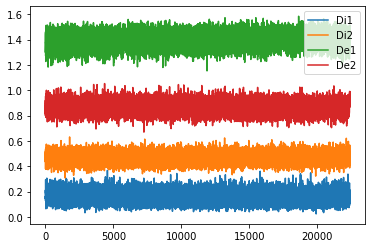

EPOCH : 332 BATCH :  37 DISC LOSS :  [0.14084552, 0.06689011, 0.0648641, 0.009091299, 0.0, 0.9375, 1.0] DEC LOSS :  [1.4188062, 0.7165687, 0.70213187, 0.0, 0.0] ENC LOSS :  108.85239
DISC LOSS 2 :  [0.49732545, 0.31340194, 0.087650366, 0.09627315, 0.0, 0.875, 0.9375] DEC LOSS 2 :  [0.9208856, 0.476153, 0.4446242, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


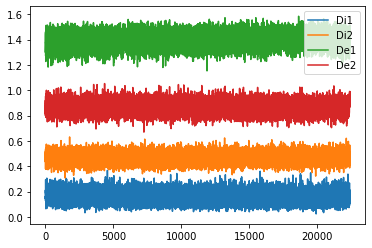

EPOCH : 332 BATCH :  38 DISC LOSS :  [0.15217482, 0.09659253, 0.054421626, 0.0011606638, 0.0, 0.96875, 1.0] DEC LOSS :  [1.4237669, 0.66132796, 0.76233375, 0.0, 0.0] ENC LOSS :  109.659294
DISC LOSS 2 :  [0.46672612, 0.27443847, 0.107317306, 0.08497034, 0.0, 0.875, 0.96875] DEC LOSS 2 :  [0.96438426, 0.49354637, 0.47073, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


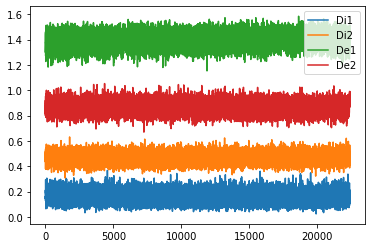

EPOCH : 332 BATCH :  39 DISC LOSS :  [0.19537956, 0.09605461, 0.07752296, 0.021801978, 0.0, 0.90625, 0.96875] DEC LOSS :  [1.3396128, 0.62403005, 0.71547663, 0.0, 0.0] ENC LOSS :  108.54987
DISC LOSS 2 :  [0.523305, 0.36466104, 0.08159486, 0.07704909, 0.0, 0.9375, 1.0] DEC LOSS 2 :  [0.97509307, 0.4826897, 0.4922998, 0.0, 0.0]


/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


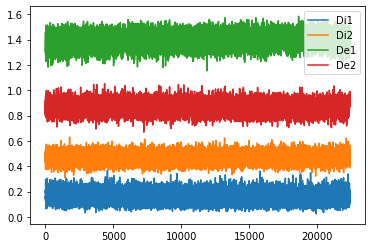

EPOCH : 332 BATCH :  40 DISC LOSS :  [0.16960758, 0.11096426, 0.05522696, 0.0034163615, 0.0, 0.9375, 1.0] DEC LOSS :  [1.3545995, 0.61539084, 0.73910433, 0.0, 0.0] ENC LOSS :  108.74397
DISC LOSS 2 :  [0.49049374, 0.3237343, 0.09634386, 0.070415586, 0.0, 0.90625, 0.96875] DEC LOSS 2 :  [0.9659219, 0.47873592, 0.48708177, 0.0, 0.0]
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)
(1, 1, 5, 3)


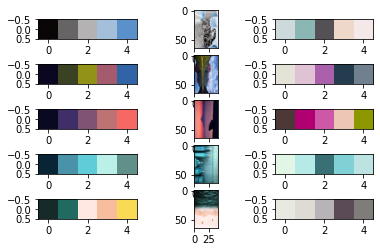

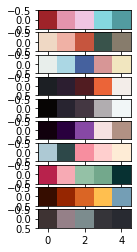

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
epochs = 200000
seed = 0
#rng = np.random.RandomState(seed)
#y_real = np.ones((batch_size,), dtype='float32')
y_real = np.random.uniform(low=0.075, high=1.0, size=(batch_size,))
y_fake = np.zeros((batch_size,), dtype='float32')

dil = []
dil2 = []
deloss = []
deloss2 = []
enloss = []
start_epoch = 0


discriminator_train.load_weights("/content/gdrive/My Drive/ColorPalettes/Models/discriminator.h5")
discriminator_train2.load_weights("/content/gdrive/My Drive/ColorPalettes/Models/discriminator2.h5")
decoder_train.load_weights("/content/gdrive/My Drive/ColorPalettes/Models/decoder.h5")
decoder_train2.load_weights("/content/gdrive/My Drive/ColorPalettes/Models/decoder2.h5")
encoder_train.load_weights("/content/gdrive/My Drive/ColorPalettes/Models/encoder.h5")

dil, dil2, deloss, deloss2, enloss = np.load("/content/gdrive/My Drive/ColorPalettes/Models/loss_hist.npy")
start_epoch = np.load("/content/gdrive/My Drive/ColorPalettes/Models/start_epoch.npy")[0]


for e in range(start_epoch, epochs):
    if e % 1 == 0:
        discriminator_train.save("/content/gdrive/My Drive/ColorPalettes/Models/discriminator.h5".format(e))
        discriminator_train2.save("/content/gdrive/My Drive/ColorPalettes/Models/discriminator2.h5".format(e))
        decoder_train.save("/content/gdrive/My Drive/ColorPalettes/Models/decoder.h5".format(e))
        decoder_train2.save("/content/gdrive/My Drive/ColorPalettes/Models/decoder2.h5".format(e))
        encoder_train.save("/content/gdrive/My Drive/ColorPalettes/Models/encoder.h5".format(e))

        np.save("/content/gdrive/My Drive/ColorPalettes/Models/loss_hist", np.array([dil, dil2, deloss, deloss2, enloss]))
        np.save("/content/gdrive/My Drive/ColorPalettes/Models/start_epoch", np.array([e]))
    for i, (img, colors) in enumerate(train_loader.load_batch()):
        y_real = np.random.normal(0.9, 0.01, size=(batch_size,))
        colors = np.squeeze(colors)

        z_p = np.random.normal(0, 0.5, size=(batch_size, latent_dim_size))
        z_noise = np.random.normal(0, 0.5, size=(batch_size, int(latent_dim_size/4)))
        disc_loss = discriminator_train.train_on_batch([colors, img, z_p, z_noise], [y_real, y_fake, y_fake])
        disc_loss2 = discriminator_train2.train_on_batch([colors, img, z_p, z_noise], [y_real, y_fake, y_fake])

        dil = np.append(dil, disc_loss[0])
        dil2 = np.append(dil2, disc_loss2[0])

        dec_loss = decoder_train.train_on_batch([colors, img, z_p, z_noise], [y_real, y_real])
        dec_loss2 = decoder_train2.train_on_batch([colors, img, z_p, z_noise], [y_real, y_real])
        deloss = np.append(deloss, dec_loss[0])
        deloss2 = np.append(deloss2, dec_loss2[0])

        enc_loss = encoder_train.train_on_batch([colors, img, z_noise], None)
        enloss = np.append(enloss, enc_loss)

        plt.plot(dil, label="Di1")
        plt.plot(dil2, label="Di2")
        plt.plot(deloss, label="De1")
        plt.plot(deloss2, label="De2")
        plt.legend()
        plt.show()

        print("EPOCH :", e, "BATCH : ", i, "DISC LOSS : ", disc_loss, "DEC LOSS : ", dec_loss, "ENC LOSS : ", enc_loss)
        print("DISC LOSS 2 : ", disc_loss2, "DEC LOSS 2 : ", dec_loss2)

        if i % 20 == 0:
            for j, (ti, tc) in enumerate(test_loader.load_batch()):
                z_noise = np.random.normal(0, 0.5, size=(batch_size, int(latent_dim_size/4)))
                print(tc.shape)
                # Evaluating
                recon = vae.predict([ti, z_noise])[0]

                plt.subplot(5, 3, j*3 + 1)
                show_image(tc[0])

                plt.subplot(5, 3, j*3 + 2)
                show_image(ti[0])

                plt.subplot(5, 3, j*3 + 3)
                show_image(np.array([recon]))

                if j == 4:
                    break
            plt.show()
            #plt.savefig("vaegantest/predictions_{}_{}".format(e, i))
            #plt.close('all')

            for j, (ti, tc) in enumerate(test_loader.load_batch()):
                z = np.random.normal(0, 0.5, size=(1, latent_dim_size))
                z_noise = np.random.normal(0, 0.5, size=(batch_size, int(latent_dim_size/4)))
                new = decoder.predict([z, z_noise])

                plt.subplot(10, 1, j+1)
                show_image(new)

                if j == 9:
                    break

            #plt.savefig("vaegantest/sampled_{}_{}".format(e, i))
            plt.show()
            #plt.close('all')

In [ ]:
import matplotlib.gridspec as gridspec

def normalize_lab(lab):
    L, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

    L = (L / 50 ) - 1
    a = a / 128
    b = b / 128

    Lab = np.stack([L, a, b], axis=2)
    return Lab

from PIL import Image

plt.axis('off')
for i, batch in enumerate(test_loader.load_batch()):
    
    img = batch[0][0]
   # print(img.shape)

    #plt.axis('off')
    #plt.subplot(1,2,1)
    #plt.axis('off')
    #show_image(batch[0][0])

    z_noise = np.random.normal(0, 1, size=(batch_size, int(latent_dim_size/4)))
    palette = vae.predict([np.asarray([batch[0][0]]), z_noise])
    #print(palette.shape)
    #plt.axis('off')
    #plt.subplot(1,2,2)
    plt.axis('off')
    show_image(palette)
    

    plt.savefig('/content/gdrive/My Drive/ColorPalettes/imgs/gan/palette_{}.png'.format(i))
    plt.show()
    img = denormalize_lab(batch[0][0])
    img = color.lab2rgb(img)

'''
for i in range(1,2):
    im = Image.open('{}.jpg'.format(i))
    print(im.size)
    img = np.array(im)[200:1000,750:1200]
    plt.imshow(img)
    plt.show()
    plt.axis('off')
    fig2 = plt.figure(constrained_layout=True)
    spec2 = gridspec.GridSpec(ncols=2, nrows=10, figure=fig2)
    f2_ax1 = fig2.add_subplot(spec2[:, 0])
    f2_ax1.axis('off')
    f2_ax1.imshow(im)

    im = np.array(np.resize(np.array(im)[200:1000,750:1200], (64,40,3))) / 127.5 - 0.5
    
    im = color.rgb2lab(im[:,:,:3])

    im = normalize_lab(im)

    #print(latent_code)
    #plt.imshow(latent_code.reshape([latent_code.shape[-1] // latent_dim_div, -1]))
    #plt.show()
    z_noise1 = np.random.normal(0, 0.5, size=(batch_size, int(latent_dim_size/4)))
    z_noise2 = np.random.normal(0, 0.5, size=(batch_size, int(latent_dim_size/4)))
    noises = []

    n = 10
    for j in range(n):
        print(j/n)
        noises.append(z_noise1 * (j/n) + z_noise2 * (1 - (j/n)))

    
    for j, noise in enumerate(noises):
        
        palette = vae.predict([np.array([im]), noise])
        gs = fig2.add_subplot(spec2[j, 1])
        palette = denormalize_lab(palette)
        palette = color.lab2rgb(palette)
        gs.axis('off')
        gs.imshow(palette)
    print(i)
    plt.savefig("sample_data/samples/sample_{}.png".format(i))
    plt.show()
    
'''     

In [ ]:
import matplotlib.gridspec as gridspec

def normalize_lab(lab):
    L, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

    L = (L / 50 ) - 1
    a = a / 128
    b = b / 128

    Lab = np.stack([L, a, b], axis=2)
    return Lab


n = 7

for p in range(10):
    fig = plt.figure(constrained_layout=True)
    spec = gridspec.GridSpec(ncols=n, nrows=n, figure=fig)

    latent1 = np.random.normal(0, 0.5, size=(1, int(latent_dim_size)))
    latent2 = np.random.normal(0, 0.5, size=(1, int(latent_dim_size)))

    print(latent1.shape)

    z_noise1 = np.random.normal(0, 0.5, size=(1, int(latent_dim_size/4)))
    z_noise2 = np.random.normal(0, 0.5, size=(1, int(latent_dim_size/4)))

    latents = []
    noises = []


    for j in range(n):
        latents.append(latent1 * (j/n) + latent2 * (1 - (j/n)))
        noises.append(z_noise1 * (j/n) + z_noise2 * (1 - (j/n)))

    

    for i in range(n):
        for j in range(n):
            palette = decoder.predict([latents[i], noises[j]])
        
            gs = fig.add_subplot(spec[i, j])
            palette = denormalize_lab(palette)
            palette = color.lab2rgb(palette)
            gs.axis('off')
            gs.imshow(palette)



    plt.savefig("sample_data/samples/interpolations_{}.png".format(p))
    plt.show()
    
        